In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
sampled_features = pd.read_csv('../data/sampled_features.csv', 
                               index_col=[0], 
                               header=[0,1,2])
sampled_features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
32081        -0.149236  0.348979 -0.256342  0.818010 -0.754737  0.595361   
138317       -0.024289 -0.320302 -0.571483  0.589557 -0.790646  0.336780   
125817        0.568068 -0.857945  0.861216 -1.016349 -0.560541 -0.892692   
117172       -0.492603 -0.944479 -0.732962 -0.879166 -0.951663 -0.611848   
131789        0.107442  1.453892  0.412687  0.914714 -0.158467  0.807896   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        05        06   
track_id                                            ...                       
32081      -0.575464  0.118675 -1.128392 -1.013314  ...  0.021267  0.018633   
138317      1.850241  1.266195  0.189149 -0.537890  ...  0.021862  0.020002   
125817     -1.317466  2.829233 -1.598327 -1.633583  ...  0.034048  0.047383   
117172     -0.969072 -0.495137 -0.722001  0.253871  ...  0.029845  0.023364   
131789      2.293441  6.171995  0.721523  0.457123  ...  0.020036  0.019293   

feature           zcr                                                    \
statistics   kurtosis       max      mean    median       min      skew   
number             01        01        01        01        01        01   
track_id                                                                  
32081       27.748169  0.374023  0.057702  0.051270  0.000000  4.503321   
138317       8.863070  0.256836  0.058061  0.054199  0.011719  1.982626   
125817      97.155006  0.397949  0.014030  0.007812  0.002441  8.558769   
117172       5.088123  0.191406  0.029363  0.020020  0.002441  1.997258   
131789      16.671103  0.528320  0.050367  0.035156  0.000000  3.597306   

feature                             genre  
statistics       std Unnamed: 519_level_1  
number            01 Unnamed: 519_level_2  
track_id                                   
32081       0.037173                 Rock  
138317      0.024780                 Rock  
125817      0.024152                 Rock  
117172      0.024906                 Rock  
131789      0.052730                 Rock  

[5 rows x 519 columns]

In [3]:
sampled_features.shape

(1600, 519)

In [4]:
X = sampled_features.iloc[:, :518].to_numpy()

In [5]:
labels = sampled_features.iloc[:, 518:]
labels.columns = ['genre']
labels = np.array(labels['genre'])
labels.shape

(1600,)

In [6]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        sc = StandardScaler()
        X = sc.fit_transform(X)

        pca = PCA(n_components=self.q).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

In [7]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [8]:
def bench_af(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, 
             (time() - t0),
             len(estimator.cluster_centers_indices_),
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=1600)))

In [9]:
print(82 * '_')
print('init\t\ttime\t#_clusters\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
bench_af(AffinityPropagation(damping=0.5, 
                             max_iter=200, 
                             convergence_iter=15),
         name="default", 
         data=X)
pca = PCA(n_components=10).fit_transform(X)
bench_af(AffinityPropagation(damping=0.5, 
                             max_iter=200, 
                             convergence_iter=15),
         name="PCA-default",
         data=pca)
pfa_object = PFA(n_features=10)
pfa_object.fit(X)
pfa = pfa_object.features_
bench_af(AffinityPropagation(damping=0.5, 
                             max_iter=200, 
                             convergence_iter=15),
         name="PFA-default",
         data=pfa)
bench_af(AffinityPropagation(damping=0.75, 
                             max_iter=200, 
                             convergence_iter=10),
         name="tuned1", 
         data=X)
bench_af(AffinityPropagation(damping=0.75, 
                             max_iter=200, 
                             convergence_iter=10),
         name="PCA-tuned1",
         data=pca)
bench_af(AffinityPropagation(damping=0.75, 
                             max_iter=200, 
                             convergence_iter=10),
         name="PFA-tuned1",
         data=pfa)
bench_af(AffinityPropagation(damping=0.6, 
                             max_iter=200, 
                             convergence_iter=12),
         name="tuned2", 
         data=X)
bench_af(AffinityPropagation(damping=0.6, 
                             max_iter=200, 
                             convergence_iter=12),
         name="PCA-tuned2",
         data=pca)

bench_af(AffinityPropagation(damping=0.6, 
                             max_iter=200, 
                             convergence_iter=12),
         name="PFA-tuned2",
         data=pfa)
print(82 * '_')

__________________________________________________________________________________
init		time	#_clusters	homo	compl	v-meas	ARI	AMI	silhouette
default  	1.92s	62	0.221	0.080	0.117	0.021	0.065	0.140
PCA-default	2.11s	62	0.224	0.080	0.118	0.018	0.065	0.145
PFA-default	3.61s	120	0.220	0.068	0.104	0.009	0.042	0.097
tuned1   	2.16s	59	0.210	0.076	0.112	0.022	0.062	0.143
PCA-tuned1	1.92s	63	0.224	0.079	0.117	0.020	0.064	0.143
PFA-tuned1	1.91s	120	0.219	0.068	0.104	0.009	0.042	0.094
tuned2   	1.73s	61	0.221	0.079	0.117	0.022	0.065	0.138
PCA-tuned2	1.72s	62	0.218	0.079	0.115	0.023	0.063	0.141
PFA-tuned2	3.05s	120	0.221	0.069	0.105	0.009	0.043	0.096
__________________________________________________________________________________


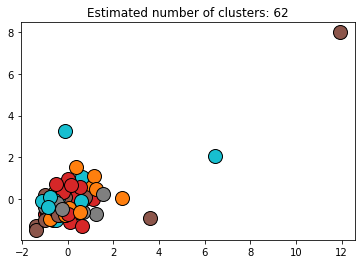

In [11]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

af = AffinityPropagation(damping=0.5, 
                             max_iter=200, 
                             convergence_iter=15)
af.fit(X)
cluster_centers_indices = af.cluster_centers_indices_

#colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k in range(len(af.cluster_centers_indices_)):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1])#, col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markeredgecolor='k', markersize=14)#, markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]])#, col)

plt.title('Estimated number of clusters: %d' % len(af.cluster_centers_indices_))
plt.show()